# Dirichlet process mixture models

[Bayesian mixture models](bayesian_mixture_models.ipynb) introduced how to infer the posterior of the parameters of a mixture model with a fixed number of components $K$. 

We can either find $K$ using model selection, i.e. with AIC, BIC, WAIC, etc., or try to automatically infer this number. Nonparametric mixture models do exactly this. Here we implement a nonparametric Bayesian mixture model for Gaussian random variables using a *Chinese restaurant process* prior and using *stick-breaking* construction. Both create samples from a *Dirichlet process* (see for instance Nils Hjort's [*Bayesian Nonparametrics*](https://www.cambridge.org/ch/academic/subjects/statistics-probability/statistical-theory-and-methods/bayesian-nonparametrics?format=HB&isbn=9780521513463) or Peter Orbanz' [lecture notes](http://stat.columbia.edu/~porbanz/papers/porbanz_BNP_draft.pdf)).

**As usual I do not take warranty for the correctness or completeness of this document.**

In [19]:
options(repr.fig.width=8, repr.plot.height=4)

## The Dirichlet process

The DP, as any BNP model, puts priors on structures that accomodate infinite sizes. The resulting posteriors give a distribution on structures that grow with new observations.

## The Chinese restaurant process

The Chinese restaurant process (CRP) is possibly the simplest case which models a distribution over partitions as prior clustering. We will first discuss how a latent CRP creates the data and then use collapsed GIbbs sampling to infer the parameters of a Gaussian DPMM.

### Data generating process

Assuming normally distributed data the CRP model is:

1. Draw the parameters of each Gaussian component:
\begin{align*}
\theta_k \sim \mathcal{N}(0, \lambda)
\end{align*}
2. For each datum $i$:
    1. Draw cluster assignment: $z_i \mid z_{1:i-1} \sim \text{CRP}(\alpha)$
    2. Draw $x_i \sim \mathcal{N}(\theta_{z_i}, \sigma^2)$
    
Above we assumed a conjugate distribution for the means $\theta_k$ and known identical variance for every component.
Let's go through that below once.

Load `e1071` to sample class labels (i.e. multinoulli).

In [31]:
library("e1071")
library("MASS")

Set a number of data points and the concentration of the Dirichlet Process.

In [108]:
n <- 1000
alpha <- 1

Latent class assignments (`Z`), the current table index and the number of customers per table.

In [118]:
Z <- integer(n)
X <- matrix(0, n, 2)
curr.tab <- 0
tables <- c()

In [119]:
sigma <- .1
mus <- NULL

Create a random assignment of customers to tables with probability $P(z_i \mid Z_{-i})$.

In [120]:
for (i in seq(n))
{   
    probs <- c(tables / (i - 1 + alpha), alpha / (i - 1 + alpha))
    table <- rdiscrete(1, probs)
    if (table > curr.tab) 
    {
        curr.tab <- curr.tab + 1
        tables <- c(tables, 0)
        mu <- MASS::mvrnorm(1, c(0, 0), 10 * diag(2))
        mus <- rbind(mus, mu)
    }
    Z[i] <- table
    X[i,] <- MASS::mvrnorm(1, mus[Z[i], ], sigma * diag(2))
    tables[table] <-  tables[table] + 1
    
}

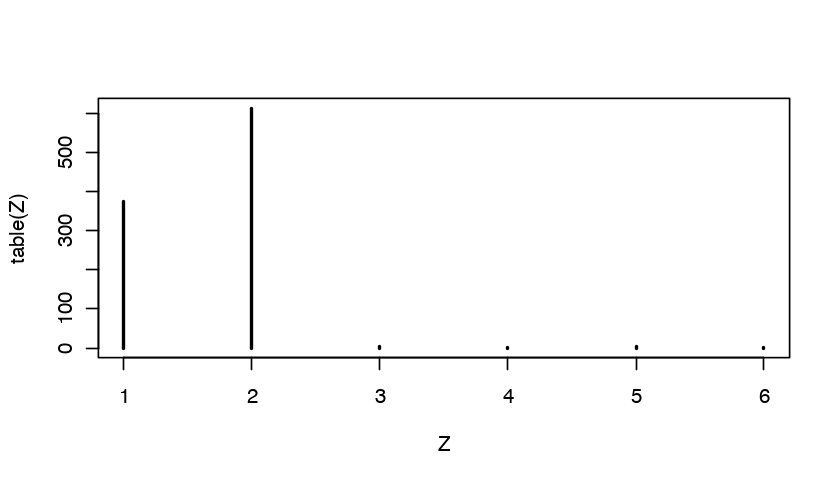

In [121]:
plot(table(Z))

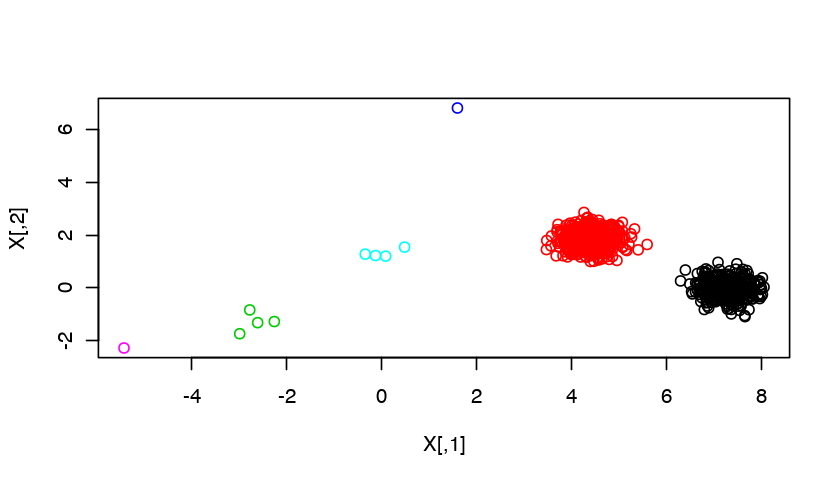

In [122]:
plot(X, col=Z)

### Posterior inference

Using conjugate prior distributions we can use collapsed Gibbs sampling for inference of the posteriors. Let's try to infer the class assignments from the generated data above.

In [126]:
alpha <- 2
mu0 <- c(0, 0)
Sigma0 <- diag(2)
G0 <- MASS::mvrnorm

In [128]:
Z <- rep(1, n)
C <- matrix(1, n, 1)
N <- c(n)
mus <- G0(1, mu0, Sigma0)

In [ ]:
C.append(np.ones(N, dtype=int))
zs[:] = 0
Ns.append(N)
mus.append(G0.rvs())
K = 1

mvn = st.multivariate_normal


In [ ]:
gem <- function(n, Z)
{
    for (i in seq(n))
    {
        zi <- Z[i]
        C[zi, i] <- 0
        N[i] <- N[i] - 1
        
        if (N[i] == 0) {
            Z[Z > zi] <- Z[Z > zi] - 1
            C <- C[-zi,]
            N <- N[-zi]
        }
    }

        # If empty, remove cluster
        if Ns[zi] == 0:
            # Fix indices
            zs[zs > zi] -= 1

            # Delete cluster
            del C[zi]
            del Ns[zi]
            del mus[zi]

            # Decrement cluster count
            K -= 1

        # Draw new assignment zi weighted by CRP prior
        # --------------------------------------------

        probs = np.zeros(K+1)
        zs_minus_i = zs[np.arange(len(zs)) != i]

        # Probs of joining existing cluster
        for k in range(K):
            nk_minus = zs_minus_i[zs_minus_i == k].shape[0]
            crp = nk_minus / (N + alpha - 1)
            probs[k] = crp * mvn.pdf(X[i], mus[k], sigma)

        # Prob of creating new cluster
        crp = alpha / (N + alpha - 1)
        lik = mvn.pdf(X[i], mu0, sigma0+sigma)  # marginal dist. of x
        probs[K] = crp*lik

        # Normalize
        probs /= np.sum(probs)

        # Draw new assignment for i
        z = np.random.multinomial(n=1, pvals=probs).argmax()

        # Update assignment trackers
        if z == K:
            C.append(np.zeros(N, dtype=int))
            Ns.append(0)
            mus.append(G0.rvs())
            K += 1

        zs[i] = z
        C[z][i] = 1
        Ns[z] += 1

}

In [ ]:
for (i in seq(20))
{
    for i in range(N):
        # Remove assignment from cluster
        # ------------------------------

        zi = zs[i]
        C[zi][i] = 0
        Ns[zi] -= 1

        # If empty, remove cluster
        if Ns[zi] == 0:
            # Fix indices
            zs[zs > zi] -= 1

            # Delete cluster
            del C[zi]
            del Ns[zi]
            del mus[zi]

            # Decrement cluster count
            K -= 1

        # Draw new assignment zi weighted by CRP prior
        # --------------------------------------------

        probs = np.zeros(K+1)
        zs_minus_i = zs[np.arange(len(zs)) != i]

        # Probs of joining existing cluster
        for k in range(K):
            nk_minus = zs_minus_i[zs_minus_i == k].shape[0]
            crp = nk_minus / (N + alpha - 1)
            probs[k] = crp * mvn.pdf(X[i], mus[k], sigma)

        # Prob of creating new cluster
        crp = alpha / (N + alpha - 1)
        lik = mvn.pdf(X[i], mu0, sigma0+sigma)  # marginal dist. of x
        probs[K] = crp*lik

        # Normalize
        probs /= np.sum(probs)

        # Draw new assignment for i
        z = np.random.multinomial(n=1, pvals=probs).argmax()

        # Update assignment trackers
        if z == K:
            C.append(np.zeros(N, dtype=int))
            Ns.append(0)
            mus.append(G0.rvs())
            K += 1

        zs[i] = z
        C[z][i] = 1
        Ns[z] += 1

    # -------------------------------------------------
    # Sample from full conditional of cluster parameter
    # -------------------------------------------------

    # Assume fixed covariance => posterior is Normal
    # mu ~ N(mu, sigma)
    for k in range(K):
        Xk = X[zs == k]
        Ns[k] = Xk.shape[0]

        # Covariance of posterior
        lambda_post = prec0 + Ns[k]*prec
        cov_post = np.linalg.inv(lambda_post)

        # Mean of posterior
        left = cov_post
        right = prec0 @ mu0 + Ns[k]*prec @ np.mean(Xk, axis=0)
        mus_post = left @ right

        # Draw new mean sample from posterior
        mus[k] = mvn.rvs(mus_post, cov_post)
}

In [11]:

mus = []  # List of 2x1 vector (mean vector of each gaussian)
sigma = np.eye(D)
prec = np.linalg.inv(sigma)  # Fixed precision matrix for all Gaussians
zs = np.zeros([N], dtype=int)  # Assignments
C = []  # Cluster: binary matrix of K x M
Ns = []  # Count of each cluster

# CRP prior
alpha = 100

# Base distribution prior: N(mu0, prec0)
mu0 = np.ones(D)
sigma0 = np.eye(D)
prec0 = np.linalg.inv(np.eye(D))
G0 = st.multivariate_normal(mean=mu0, cov=np.eye(D))


# Initialize with ONE cluster
C.append(np.ones(N, dtype=int))
zs[:] = 0
Ns.append(N)
mus.append(G0.rvs())
K = 1

mvn = st.multivariate_normal


# Gibbs sampler
for it in range(20):
    # --------------------------------------------------------
    # Sample from full conditional of assignment from CRP prior
    # z ~ GEM(alpha)
    # --------------------------------------------------------

    # For each data point, draw the cluster assignment
    for i in range(N):
        # Remove assignment from cluster
        # ------------------------------

        zi = zs[i]
        C[zi][i] = 0
        Ns[zi] -= 1

        # If empty, remove cluster
        if Ns[zi] == 0:
            # Fix indices
            zs[zs > zi] -= 1

            # Delete cluster
            del C[zi]
            del Ns[zi]
            del mus[zi]

            # Decrement cluster count
            K -= 1

        # Draw new assignment zi weighted by CRP prior
        # --------------------------------------------

        probs = np.zeros(K+1)
        zs_minus_i = zs[np.arange(len(zs)) != i]

        # Probs of joining existing cluster
        for k in range(K):
            nk_minus = zs_minus_i[zs_minus_i == k].shape[0]
            crp = nk_minus / (N + alpha - 1)
            probs[k] = crp * mvn.pdf(X[i], mus[k], sigma)

        # Prob of creating new cluster
        crp = alpha / (N + alpha - 1)
        lik = mvn.pdf(X[i], mu0, sigma0+sigma)  # marginal dist. of x
        probs[K] = crp*lik

        # Normalize
        probs /= np.sum(probs)

        # Draw new assignment for i
        z = np.random.multinomial(n=1, pvals=probs).argmax()

        # Update assignment trackers
        if z == K:
            C.append(np.zeros(N, dtype=int))
            Ns.append(0)
            mus.append(G0.rvs())
            K += 1

        zs[i] = z
        C[z][i] = 1
        Ns[z] += 1

    # -------------------------------------------------
    # Sample from full conditional of cluster parameter
    # -------------------------------------------------

    # Assume fixed covariance => posterior is Normal
    # mu ~ N(mu, sigma)
    for k in range(K):
        Xk = X[zs == k]
        Ns[k] = Xk.shape[0]

        # Covariance of posterior
        lambda_post = prec0 + Ns[k]*prec
        cov_post = np.linalg.inv(lambda_post)

        # Mean of posterior
        left = cov_post
        right = prec0 @ mu0 + Ns[k]*prec @ np.mean(Xk, axis=0)
        mus_post = left @ right

        # Draw new mean sample from posterior
        mus[k] = mvn.rvs(mus_post, cov_post)


# Even though we only initialize with one cluster, the result should be:
#
# Expected output:
# ----------------
# 20 data in cluster-0, mean: [ 5  5 ]
# 20 data in cluster-1, mean: [ 8  8 ]
# 10 data in cluster-2, mean: [ 20  20 ]
#
# Note: cluster label is exchangeable
for k in range(K):
    print('{} data in cluster-{}, mean: {}'.format(Ns[k], k, mus[k]))


ERROR: Error in parse(text = x, srcfile = src): <text>:1:3: unexpected string constant
3: Reference: https://pdfs.semanticscholar.org/9ece/0336316d78837076ef048f3d07e953e38072.pdf
4: "
     ^


In [129]:
# Generalized t-Distribution log PDF
t_logpdf <- function(x, mu, v, df)
{
  g <- lgamma(0.5 * df + 0.5) - lgamma(0.5 * df) - log(sqrt(df * pi * v))
  return(g - 0.5 * (df + 1) * log(1 + (1 / df) * ((x - mu)^2) / v))
}

# Normalize a log probability vector without numerical underflow/overflow
normalize_logprob <- function(log.prob)
{
  # Compute the log of the normalizing constant.
  g <- log(sum(exp(log.prob - max(log.prob)))) + max(log.prob)
  
  # Find probabilities by exponentiating normalized log probabilities.
  return(exp(log.prob - g))
}

# Calculate the log likelihood for the Gaussian DP mixture model
# Mean and variance parameters marginalized under normal-gamma prior
# This corresponds to a generalized Student's t-distribution
# NB: some constant terms are ignored
dpmm_loglik <- function(xn, x, tau0, beta0, mu0, kappa0)
{
  N <- length(x)
  kappaN <- kappa0 + N
  tauN <- tau0 + N / 2
  
  if (N > 0)
  {
    # If there previous observations, use the current posterior.
    xm <- mean(x)
    betaN <- beta0 + 0.5 * sum((x - xm)^2) + (kappa0 * N *(xm - mu0)^2) / (2 * kappaN)
    muN <- (kappa0 * mu0 + N * xm) / kappaN
  }
  else
  {
    # If there are no previous observations, revert to the prior.
    betaN <- beta0
    muN <- mu0
  }
  
  return(t_logpdf(xn, muN, betaN * (kappaN + 1) / (tauN * kappaN), 2 * kappaN))
}

# Gibbs sampling for the Gaussian Dirichlet process mixture model
#
# Inputs:
#  x - data (vector of length N)
#  alpha - DP concentration parameter
#  tau0 - normal-gamma prior shape
#  beta0 - normal-gamma prior rate (inverse scale)
#  kappa0 - normal-gamma prior precision scaling parameter
#  nIter - number of Gibbs iterations
#
# Outputs:
#  C, a N x nIter matrix of cluster assignments
dpmm_gibbs <- function(x, alpha, tau0, beta0, mu0, kappa0, nIter)
{
  N <- length(x)
  logpost <- rep(1, 1, nIter)
  p <- rep(1, 1, N)
  C <- matrix(data = NA, nrow = N, ncol = nIter)
  c <-rep(1, 1, N)
  m <- rep(0, 1, N)
  m[1] <- N
  logprior <- rep(1, 1, N)
  loglik <- rep(1, 1, N)
  ix <- 1:N
  
  for (i in 1:nIter)
  {
    print(paste("Iteration", i))
    
    for (n in 1:N)
    {
      #all customers except n
      cn <- c[1:N!=n]
      
      #count cluster assignments
      for (k in 1:N)
      {
        m[k] <- sum(cn == k)
      }
      
      if (all(m > 0))
      {
        #active dishes
        K.active <- ix[m > 0]
      }
      else
      {
        #active dishes + 1 new dish
        K.active <- c(ix[m > 0], min(ix[m == 0]))
      }
      for (k in K.active)
      {
        if (m[k] > 0)
        {
          #prior for old dish
          logprior[k] <- log(m[k])
        }
        else
        {
          #prior for new dish
          logprior[k] <- log(alpha)
        }
        #calculate log likelihood
        loglik[k] <- dpmm_loglik(x[n], x[c==k], tau0, beta0, mu0, kappa0)
      }
      
      #posterior
      post <- normalize_logprob(logprior[K.active] + loglik[K.active])
      
      #update cluster assignment
      c[n] <- sample(K.active, 1, rep = TRUE, prob = post)
    }
    
    C[,i] = c
  }
  C
}

In [130]:
x <- c(rnorm(100, 100, 8), rnorm(50, 200, 25), rnorm(50, 25, 1))
labels <- c(rep("A", 100), rep("B", 50), rep("C", 50))
df <- data.frame(X = x, Label = labels)

In [131]:
library(ggplot2)

nIter <- 100
results <- dpmm_gibbs(x, 0.01, 0.1, 0.1, 0, 0.1, nIter)
results[, nIter]

[1] "Iteration 1"
[1] "Iteration 2"
[1] "Iteration 3"
[1] "Iteration 4"
[1] "Iteration 5"
[1] "Iteration 6"
[1] "Iteration 7"
[1] "Iteration 8"
[1] "Iteration 9"
[1] "Iteration 10"
[1] "Iteration 11"
[1] "Iteration 12"
[1] "Iteration 13"
[1] "Iteration 14"
[1] "Iteration 15"
[1] "Iteration 16"
[1] "Iteration 17"
[1] "Iteration 18"
[1] "Iteration 19"
[1] "Iteration 20"
[1] "Iteration 21"
[1] "Iteration 22"
[1] "Iteration 23"
[1] "Iteration 24"
[1] "Iteration 25"
[1] "Iteration 26"
[1] "Iteration 27"
[1] "Iteration 28"
[1] "Iteration 29"
[1] "Iteration 30"
[1] "Iteration 31"
[1] "Iteration 32"
[1] "Iteration 33"
[1] "Iteration 34"
[1] "Iteration 35"
[1] "Iteration 36"
[1] "Iteration 37"
[1] "Iteration 38"
[1] "Iteration 39"
[1] "Iteration 40"
[1] "Iteration 41"
[1] "Iteration 42"
[1] "Iteration 43"
[1] "Iteration 44"
[1] "Iteration 45"
[1] "Iteration 46"
[1] "Iteration 47"
[1] "Iteration 48"
[1] "Iteration 49"
[1] "Iteration 50"
[1] "Iteration 51"
[1] "Iteration 52"
[1] "Iteration 53"
[1

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

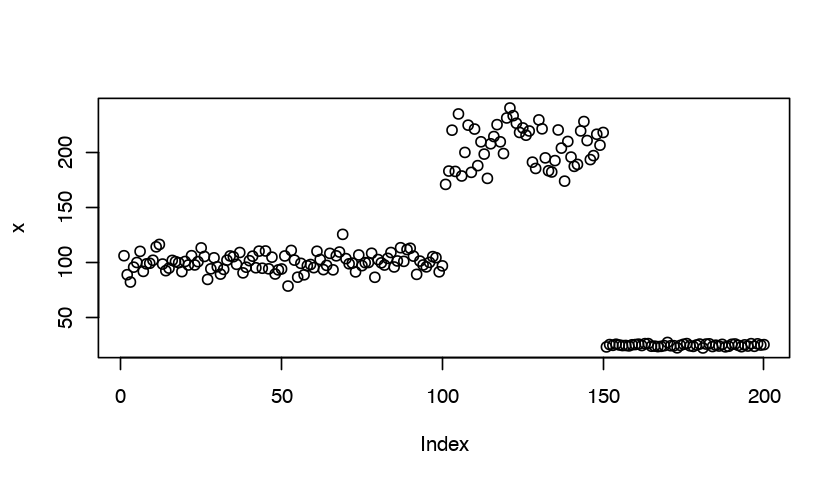

In [136]:
plot(x, col=results[,10])

In [140]:

library(mixtools)
library(ggplot2)
library(tidyverse)
library(magrittr)


dat_generator <- function(truth) 
{
    set.seed(1)
    n = 500
    
    f = function(x) {
        out = numeric(length(x))
        for (i in 1:length(truth$pi)) out = out + truth$pi[i] * dnorm(x, truth$mu[i], 
            truth$sigma[i])
        out
    }
    y = rnormmix(n, truth$pi, truth$mu, truth$sigma)
    for (i in 1:length(truth$pi)) {
        assign(paste0("y", i), rnorm(n, truth$mu[i], truth$sigma[i]))
    }
    dat <- data_frame(y = y, y1 = y1, y2 = y2, y3 = y3)
}

truth = data.frame(pi = c(0.1, 0.5, 0.4), mu = c(-3, 0, 3), sigma = sqrt(c(0.5, 0.75, 1)))
dat <- dat_generator(truth)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.1     ✔ dplyr   0.7.6
✔ readr   1.1.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
Warning message:
“package ‘dplyr’ was built under R version 3.5.1”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



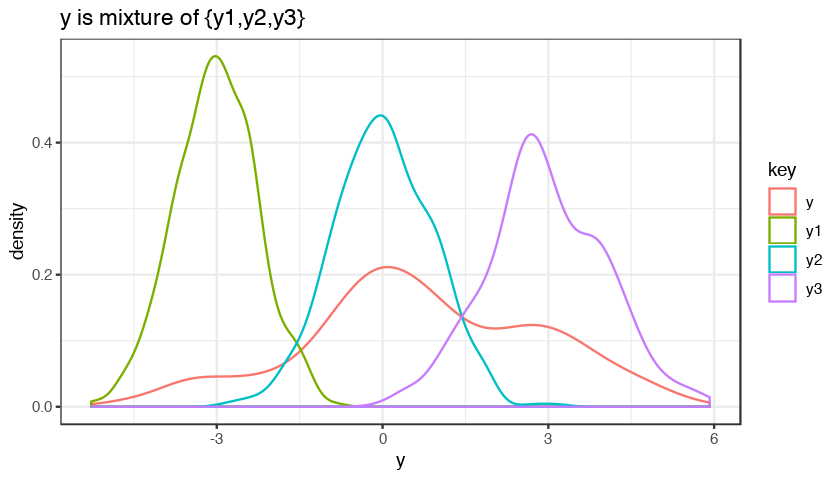

In [145]:
dat %>% 
gather(key, value) %>%
ggplot( aes(value)) + 
geom_density(aes(color = key)) + 
    theme_bw() + xlab("y") + ggtitle("y is mixture of {y1,y2,y3}")

In [ ]:
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

stan_model <- "
data{
  int<lower=0> C;//num of cludter
  int<lower=0> N;//data num
  real y[N];
}

parameters {
  real mu_cl[C]; //cluster mean
  real <lower=0,upper=1> v[C];
  real<lower=0> sigma_cl[C]; // error scale
  //real<lower=0> alpha; // hyper prior DP(alpha,base)
}

transformed parameters{
  simplex [C] pi;
  pi[1] = v[1];
  // stick-break process based on The BUGS book Chapter 11 (p.294)
  for(j in 2:(C-1)){
      pi[j]= v[j]*(1-v[j-1])*pi[j-1]/v[j-1]; 
  }
  pi[C]=1-sum(pi[1:(C-1)]); // to make a simplex.
}

model {
  real alpha = 1;
  real a=0.001;
  real b=0.001;
  real ps[C];
  sigma_cl ~ inv_gamma(a,b);
  mu_cl ~ normal(0,5);
  //alpha~gamma(6,1);
  v ~ beta(1,alpha);
  
  for(i in 1:N){
    for(c in 1:C){
      ps[c]=log(pi[c])+normal_lpdf(y[i]|mu_cl[c],sigma_cl[c]);
    }
    target += log_sum_exp(ps);
  }

}
"
y <- dat$y
C <- 10  # to ensure large enough
N <- length(y)
input_dat <- list(y = y, N = N, C = C)
# model_object<-stan_model(model_code=stan_model)
fit <- stan(model_code = stan_model, data = input_dat, iter = 1000, chains = 1)
results <- rstan::extract(fit)

In [146]:
y <- dat$y
C <- 10
N <- length(y)
input_dat <- list(y = y, N = N, C = C)
fit <- stan(model_code = stan_model, data = input_dat, iter = 1000, chains = 1)
results <- rstan::extract(fit)

Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Attaching package: ‘rstan’

The following object is masked from ‘package:magrittr’:

    extract

The following object is masked from ‘package:tidyr’:

    extract



In file included from file2434354ece5e.cpp:8:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/core.hpp:14:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/core/matrix_vari.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/mat/fun/Eigen_NumTraits.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/prim/mat/fun/Eigen.hpp

Warning message:
“There were 479 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [147]:
plot_dat_pi <- data.frame(results$pi) %>% 
    as_data_frame() %>% 
    set_names(sprintf("pi%02d", 1:10)) 

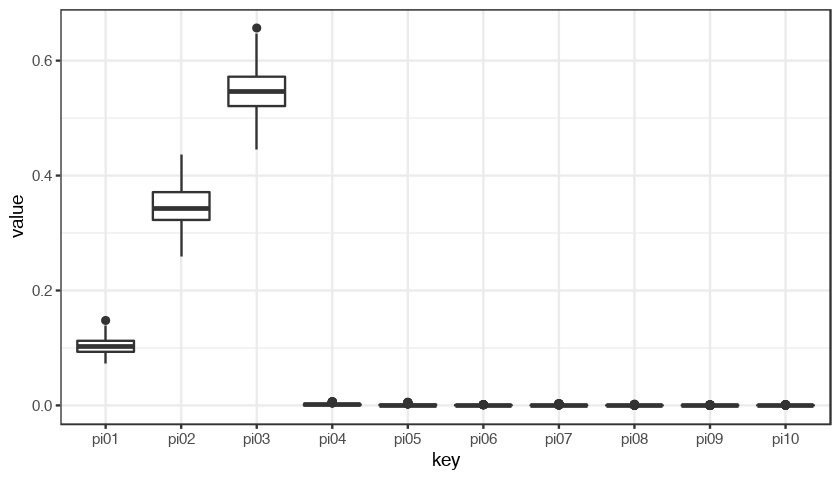

In [148]:
plot_dat_pi %>% 
    gather(key, value) %>%
    ggplot(aes(x = key, y = value)) + 
    geom_boxplot() + 
    theme_bw()


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



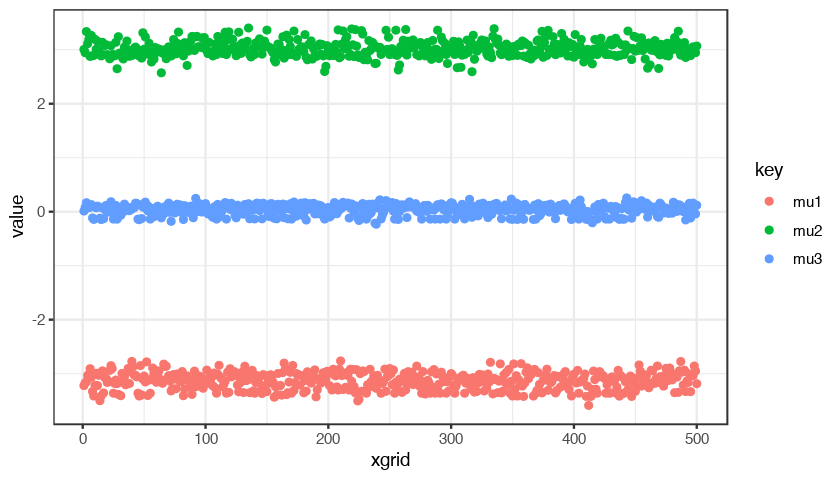

In [149]:
library(gridExtra)
plot_mu_dat <- data.frame(results$mu_cl[, 1:3]) %>% as_data_frame() %>% set_names(sprintf("mu%d", 
    1:3))
plot_mu_dat %<>% mutate(xgrid = (1:length(plot_mu_dat$mu1)))
ggplot(plot_mu_dat %>% gather(key, value, mu1:mu3), aes(x = xgrid, y = value, 
    color = key)) + geom_point() + theme_bw()